# Skill assessment - Ebro
***

**Author**: Chus Casado<br>
**Date**: 27-01-2023<br>

**Index**<br>
[__1 Data__](#1-Data)<br>
[1.1 Stations](#1.1-Stations)<br>
[1.2 Exceedance reanalysis](#1.2-Exceedance-reanalysis)<br>
[1.3 Exceedance forecast](#1.3-Exceedance-forecast)<br>
[__2 Compute events__](#2-Compute-events)<br>
[__3 Assess skill__](#3-Assess-skill)<br>

**Introduction**:<br>


**Questions**:<br>

* Should we resample to 12-hourly timesteps?
* What if every event is supposed to last 12 h?

**Tasks to do**:<br>

* [ ] Compute skill only in stations with a KGE over a threshold.
* [ ] Average `f1` score for each station.


**Interesting links**<br>
[Pythonic way to perform statistics across multiple variables with Xarray](https://towardsdatascience.com/pythonic-way-to-perform-statistics-across-multiple-variables-with-xarray-d0221c78e34a)

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs
import cartopy.feature as cf
from datetime import datetime, timedelta
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix

path_root = os.getcwd()
path_forecast = '../data/CDS/forecast/'

import warnings
warnings.filterwarnings("ignore")

os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

os.chdir('../py/')
from notifications import *
os.chdir(path_root)

## 1 Data

In [2]:
catchment = 'Loire'

# shapefile with rivers
rivers = gpd.read_file(f'../data/GIS/rivers_{catchment}.shp')

In [28]:
# path where results will be saved
path_out = f'results/{catchment}/skill/'
if os.path.exists(path_out) is False:
    os.makedirs(path_out)

### 1.1 Stations 

In [3]:
# load selected points
stations = pd.read_csv(f'results/{catchment}/points_selected.csv', index_col='station_id')
n_stations = stations.shape[0]
print('no. stations:\t{0}'.format(n_stations))

# add columns where skill will be saved
new_cols = [f'f1_{model}' for model in ['current', 'model_mean', 'weighted_mean']]
stations[new_cols] = np.nan

no. stations:	27


### 1.2 Exceedance reanalysis

In [4]:
# load probability of exceeding the discharge threshold in the REANALYSIS data
path_reanalysis = '../data/exceedance/reanalysis/'
rean_events = pd.read_parquet(f'{path_reanalysis}/events_rl5.parquet')
rean_events.columns = rean_events.columns.astype(int)
rean_events = rean_events[stations.index.tolist()]

### 1.3 Exceedance forecast

In [5]:
# models
models = {'COS': {'members': 20, 'leadtimes': 23},
          'DWD': {'members': 1, 'leadtimes': 29},
          'EUD': {'members': 1, 'leadtimes': 41},
          'EUE': {'members': 51, 'leadtimes': 41},}

In [6]:
# load probability of exceeding the discharge threshold in the FORECAST data
path_forecast = '../data/exceedance/forecast/'

fore_exc = {}
for stn in stations.index:
    fore_exc[stn] = xr.open_dataarray(f'{path_forecast}{stn:04d}.nc')

# convert into a Dataset
stn = stations.index[0]
fore_exc = xr.Dataset(fore_exc, coords={'model': fore_exc[stn].model, 'forecast': fore_exc[stn].forecast, 'leadtime': fore_exc[stn].leadtime})

In [7]:
# DataArray with weights for each model and leadtime
weights = np.zeros((len(fore_exc.model), len(fore_exc.leadtime)))
for i, (key, value) in enumerate(models.items()):
    leadtimes = value['leadtimes']
    members = value['members']
    weights[i,:leadtimes] = members
weights = xr.DataArray(weights, coords={'model': list(models), 'leadtime': fore_exc.leadtime})

## 2. Compute events

In this section I will create two boolean _DataArray_ with the onset of flood events, i.e., a matrix of zeros and ones where a one means the beginning of a flood.

* `obs_events` is a _DataArray_ with three dimensions that contains the "observed" events: 
    * `id`: the stations ID
    * `forecast`: the timestamp of the beginning of the forecast
    * `leadtime`: the timedelta of the specific timestep. The addition of forecast and leadtime renders the actual date and time of the timestep
* `pred_events` is a _DataArray_ with five dimensions that contains the forecasted events:
    * `id`
    * `forecast`
    * `leadtime`
    * `model` corresponds to the different procedures to compute the occcurrence of events.
        * `current` is the current EFAS criteria, i.e., at least a deterministic model must predict the flood, and one of the probabilistic models must predict a probability of event higher than a probability threshold.
        * `model_mean` computes total probability giving the same weight to every model, i.e., 25% weight to each of the 4 meteorological forcings.
        * `weighted_mean` computes total probability giving the same weight to each run, i.e., probabilistic models (with more than 1 run) have a higher weight.
    * `probability` are different thresholds to consider a flood event.

In [8]:
# probability thresholds
probabilities = np.arange(0.05, .96, .05).round(2)

# compute observed events and predicted events
obs_events = {}
pred_events = {}
for i, stn in enumerate(stations.index):  
    
    print(f'Station {stn:>4d} ({i+1:>4d} of {n_stations:>4d})', end='\r')

    # OBSERVED EVENTS
    # ...............
    
    # find events
    mask = rean_events[stn]
    events = rean_events.index[mask].tolist()
    # create DataArray of the occurrence of events
    obs_events[stn] = dataarray_events(events, fore_exc.forecast, fore_exc.leadtime)
    
    # COMPUTE MODEL COMBINATIONS
    # ..........................

    # mean across equally-weighted models
    model_mean = fore_exc[stn].mean('model')
    model_mean = model_mean.expand_dims('model', axis=0).assign_coords(model=['model_mean']).rename(stn)

    # weighted-mean across models
    weighted_mean = fore_exc[stn].weighted(weights).mean('model')
    weighted_mean = weighted_mean.expand_dims('model', axis=0).assign_coords(model=['weighted_mean']).rename(stn)

    # join all exceedance DataArrays
    exceedance = xr.merge([fore_exc[stn], model_mean, weighted_mean])[stn]

    pred_events_stn = xr.DataArray(dims=['model', 'forecast', 'leadtime', 'probability'],
                                   coords={'model': ['current', 'model_mean', 'weighted_mean'],
                                         'forecast': exceedance.forecast,
                                         'leadtime': exceedance.leadtime,
                                         'probability': probabilities})
    
    for j, p in enumerate(probabilities):
        
        # TIMSTEPS AT WHICH CRITERIA IS MET
        # .................................
        
        # dataset where all criteria will ve saved
        criteria = xr.Dataset(coords={'forecast': exceedance.forecast,
                                      'leadtime': exceedance.leadtime})

        # boolean auxiliary Dataset of exceedance over threshold
        aux = exceedance > p

        # find where the deterministic criteria was fulfilled
        deterministic = aux.sel(model=['DWD', 'EUD']).sum('model')
        # find where the probabilistic criteria was fulfilled
        probabilistic = aux.sel(model=['COS', 'EUE']).sum('model')
        # find where both the deterministic and the probabilistic criteria was fulfilled
        criteria['current'] = ((deterministic >= 1) & (probabilistic >= 1))
        # find where the combinations of models exceeds the probability threshold 
        for model in ['model_mean', 'weighted_mean']:
            criteria[model] = aux.sel(model=model)
        # remove variable model
        criteria = criteria.drop_vars('model')

        # FORECAST EVENTS
        # ...............

        # compute the onset of the events
        steps = criteria.astype(int).diff('leadtime') == 1
        step0 = criteria.isel(leadtime=0)
        onsets = xr.concat((step0, steps), 'leadtime')
        onsets = onsets.to_array(dim='model', name='event')
        # da_list = [onsets[model].expand_dims('model', axis=0).assign_coords(model=[model]).rename('event') for model in list(onsets)]
        # onsets = xr.merge(da_list)['event']

        pred_events_stn.loc[dict(probability=p)] = onsets
        
    pred_events[stn] = pred_events_stn

obs_events = xr.Dataset(obs_events).to_array(dim='id', name='events')
pred_events = xr.Dataset(pred_events).to_array(dim='id', name='events')

## 3 Assess skill

In this section I will compute the skill of the EFAS predictions in different ways. In all the following sections I will work with three metrics: recall, precision and the f1-score. The three metrics are based in the contingency table of hits ($TP$ for true positives), false alarms ($FP$ for false positives) and misses ($FN$ for false negatives).

$$recall = \frac{TP}{TP + FN}$$
$$precision = \frac{TP}{TP + FP}$$
$$f1 = \frac{2 \cdot TP}{2 \cdot TP + FN + FP}$$

In [9]:
metrics = {'f1': f1_score,
           'precision': precision_score,
           'recall': recall_score}

### 3.1 Skill within a forecast

In this first analysis I will check how EFAS performs at the forecast level. For that, I will aggregate the events _DataArray_ in the `leadtime` dimension, so the resulting _DataArray_ will have one dimension less and it will represent the forecasts in which there were observed (`obs_fc`) and/or predicted (`pred_fc`) events.

In [10]:
# observed events in each forecast
obs_fc = obs_events.any('leadtime')

# predicted events in each forecast
pred_fc = pred_events.any('leadtime')

# compute sums of hits and falses
tp = ((obs_fc == 1) & (pred_fc == 1)).sum('forecast')
fn = ((obs_fc == 1) & (pred_fc == 0)).sum('forecast')
fp = ((obs_fc == 0) & (pred_fc == 1)).sum('forecast')

# compute metrics and save in a Dataset
results1 = xr.Dataset({'f1': 2 * tp / (2 * tp + fn + fp),
                        'precision': tp / (tp + fp),
                        'recall': tp / (tp + fn)})

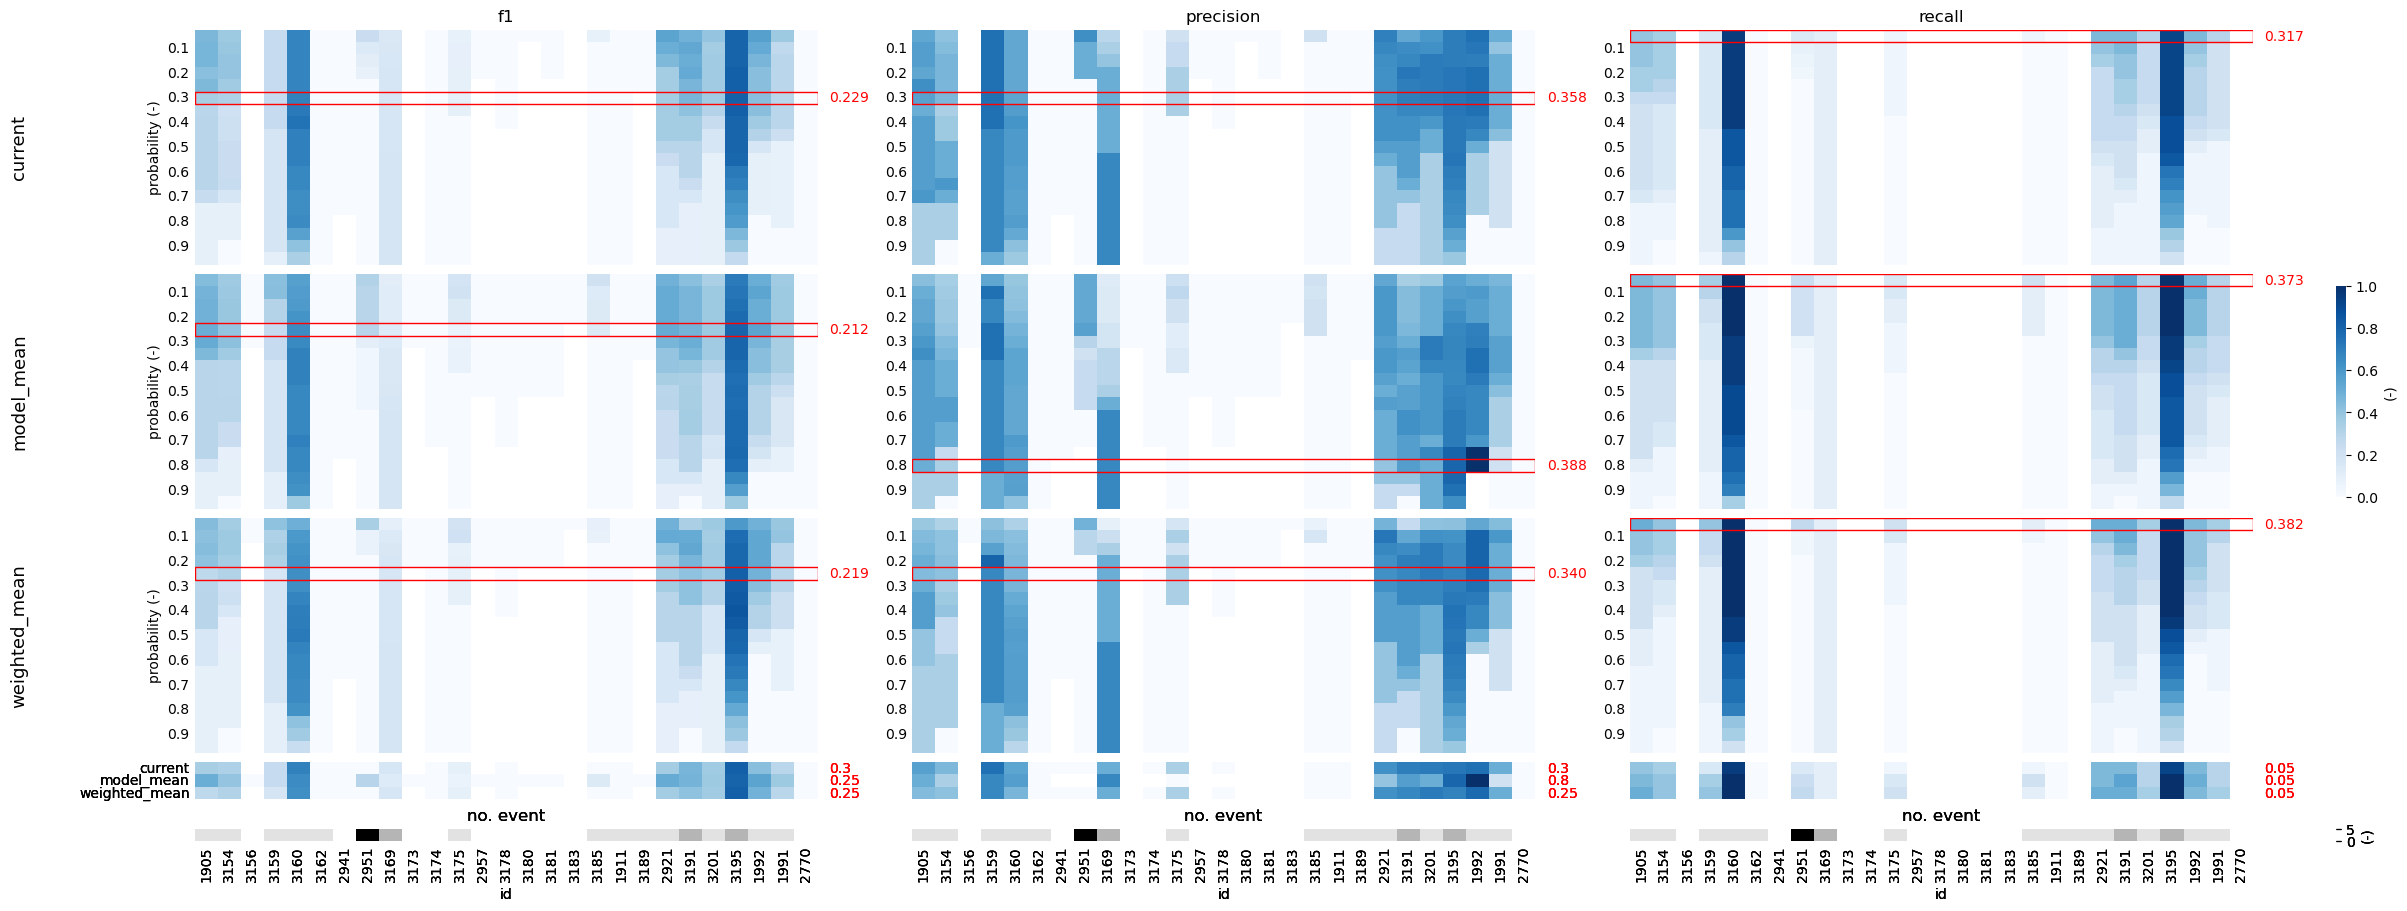

In [11]:
# plot results
plot_skill(results1, rean_events.sum())

The plot above shows the performance in terms of forecasts that predicted a flood and the flood actually occurred. The leadtime for the flood is not taking into account at this point; I consider a hit a forecast that predicts a flood at any leadtime and there actually was a flood during the complete forecasted period. 

The graph contains 15 plots distributed in 3 columns and 5 rows. Each column represents a metric: f1 (the harmonic mean of precision and recall), precision (proportion of predicted floods that were right), and recall (proportion of observed floods that were predicted). The top 3 rows represent each of the prediction criteria; they are heatmaps of the corresponding metric depending on the station and the probability threshold; the red rectangle shows the best probability threshold for that specific criteria and metric. The plots in the fourth row aggregate the red rectangles in a single plot to ease the comparison among criteria. The plots in the last row show for the amount of forecast with flood events; it is the same plot for the 3 columns.

The outcome is very interesting. In 15 out of the 50 stations there are observed events. However, there are only 9 stations in which floods are somehow predicted (metric values over 0.3). If we look at the plots in the fourth row, we check that in approx. a half of the stations (27 out of 50) there weren't neither predicted nor observed events (blank cells). However, this number of stations without predicted floods varies a lot depending on the model and the probability threshold; the lower the threshold, the more floods are predicted, reducing the overall scores.

The _current_ model get the higher score for each of the three metrics. However, to obtain these scores the probability threshold must be raised from the current 30% to 50%. The second highest ranking criteria is the *weighted_mean*, for which the best probability threshold is the current 30%. In general, the three criteria show higher precision than recall, i.e., it's likelier to be correct when it predicts a flood, but it misses observed floods. Overall, the mean scores are low. This might be caused by two factors. First, in this analysis we combine all leadtimes, which reduces the average score because distant leadtimes are more difficult to predict. Second, the low average scores are caused by some stations with poor values; if we check the plots in the fourth row, there are 9 stations with rather high scores and 14 stations with rather low scores. Interestingly, the well-performing stations are not that sensitive to the probability threshold, whereas the bad performing are. Basically, the best probability threshold is that that minimizes the amount of poor-performing stations.

### 3.2 Skill predicting the onset of the flood

In this section the analysis will be harder, and we will assess the EFAS skill at predicting the correct time of the onset of the event. Since the first tries proved that predicting the exact time of the onset is an extremely complicated task, we will consider various time windows around the observed event. A window of 3 timesteps, for instance, considers a hit when the EFAS forecast predicts the onset of the flood with an error of $\pm6\,h$.

#### 3.2.1 Find hits, misses and false alarms

After several tries, I've found a way to compute quickly and easily the skill metrics. It's importance to notice that skill metrics can't be aggregated (added or averaged) because they are quotions with an addition in the denominator. Therefore, the analysis must start computing the hits (true positives), misses (false negatives) and false alarms (false positives) without any aggregation. This first step is done in this section.

As mentioned earlier, the probability of predicting the onset of an event at the right time is very, very low. Therefore, we need to add certain flexibility in what's considered a hit, i.e., we will consider hits predictions close enough (with an offset of 1 or 2 timesteps). I came up with a procedure to count hits, misses and false alarms taking into account this flexibility on the leadtime. The plot below explains it graphically.

1. I compute a rolling sum over both the observed and predicted events. The width of the window is the flexibility we accept in the leadtime.
2. I apply a mask based on the observed events over the rolling sum of predicted events (top, right). From this matrix we can count the **true positives** (ones) and the **false negatives** (zeros).
3. I apply a mask based on the inverse of the rolling sum of observed events over the predicted events (bottom, right). The sum of ones in this matrix are the **false alarms**.

In [15]:
# number of timesteps surrounding the actual event
windows = [1, 3, 5]

hits = {var: {w: {} for w in windows} for var in ['tp', 'fn', 'fp']}
for w in windows:
    # rolling sum of observations and predictions
    mp = int(w / 2) + 1
    obs_w = obs_events.rolling({'leadtime': w}, center=True, min_periods=mp).sum() > 0
    pred_w = pred_events.rolling({'leadtime': w}, center=True, min_periods=mp).sum() > 0
    
    # compute true positives and false negatives
    aux1 = pred_w.where(obs_events == 1)
    tp, fn = (aux1 == 1), (aux1 == 0)
    
    # compute false positives
    aux2 = pred_events.where(obs_w == 0)
    fp = (aux2 == 1)
       
    # save results  
    hits['tp'][w] = tp
    hits['fn'][w] = fn
    hits['fp'][w] = fp

# convert results into a Dataset
data_vars = {var: xr.Dataset(dct).to_array(dim='window', name=var) for var, dct in hits.items()}
hits = xr.Dataset(data_vars)
# hits['leadtime'] = (pred_events.leadtime / 3600e9).astype(int)

hits.dims

Frozen({'model': 3, 'forecast': 730, 'leadtime': 40, 'probability': 19, 'id': 27, 'window': 3})

The resulting `hits` _Dataset_ has 6 dimensions: `model`, `forecast`, `leadtime`, `probability`, `id`, `window`. In the following subsection I will compute the skill metrics from this Dataset using diverse aggregations over these dimension.

#### 3.2.2 Aggregation over forecast and leadtime

Once computed the hits and misses for different time windows, the first approach will be to compute the metrics (f1, recall and precision) aggregating them over the dimensions `forecast` and `leadtime`. The resulting metrics have 4 dimensions: `model`, `probability`, `id` and `window`.

In [16]:
# compute skill
results22 = compute_metrics(hits, ['forecast', 'leadtime'])
print(results22.dims)

Frozen({'model': 3, 'probability': 19, 'id': 27, 'window': 3})


**Plot id vs window**

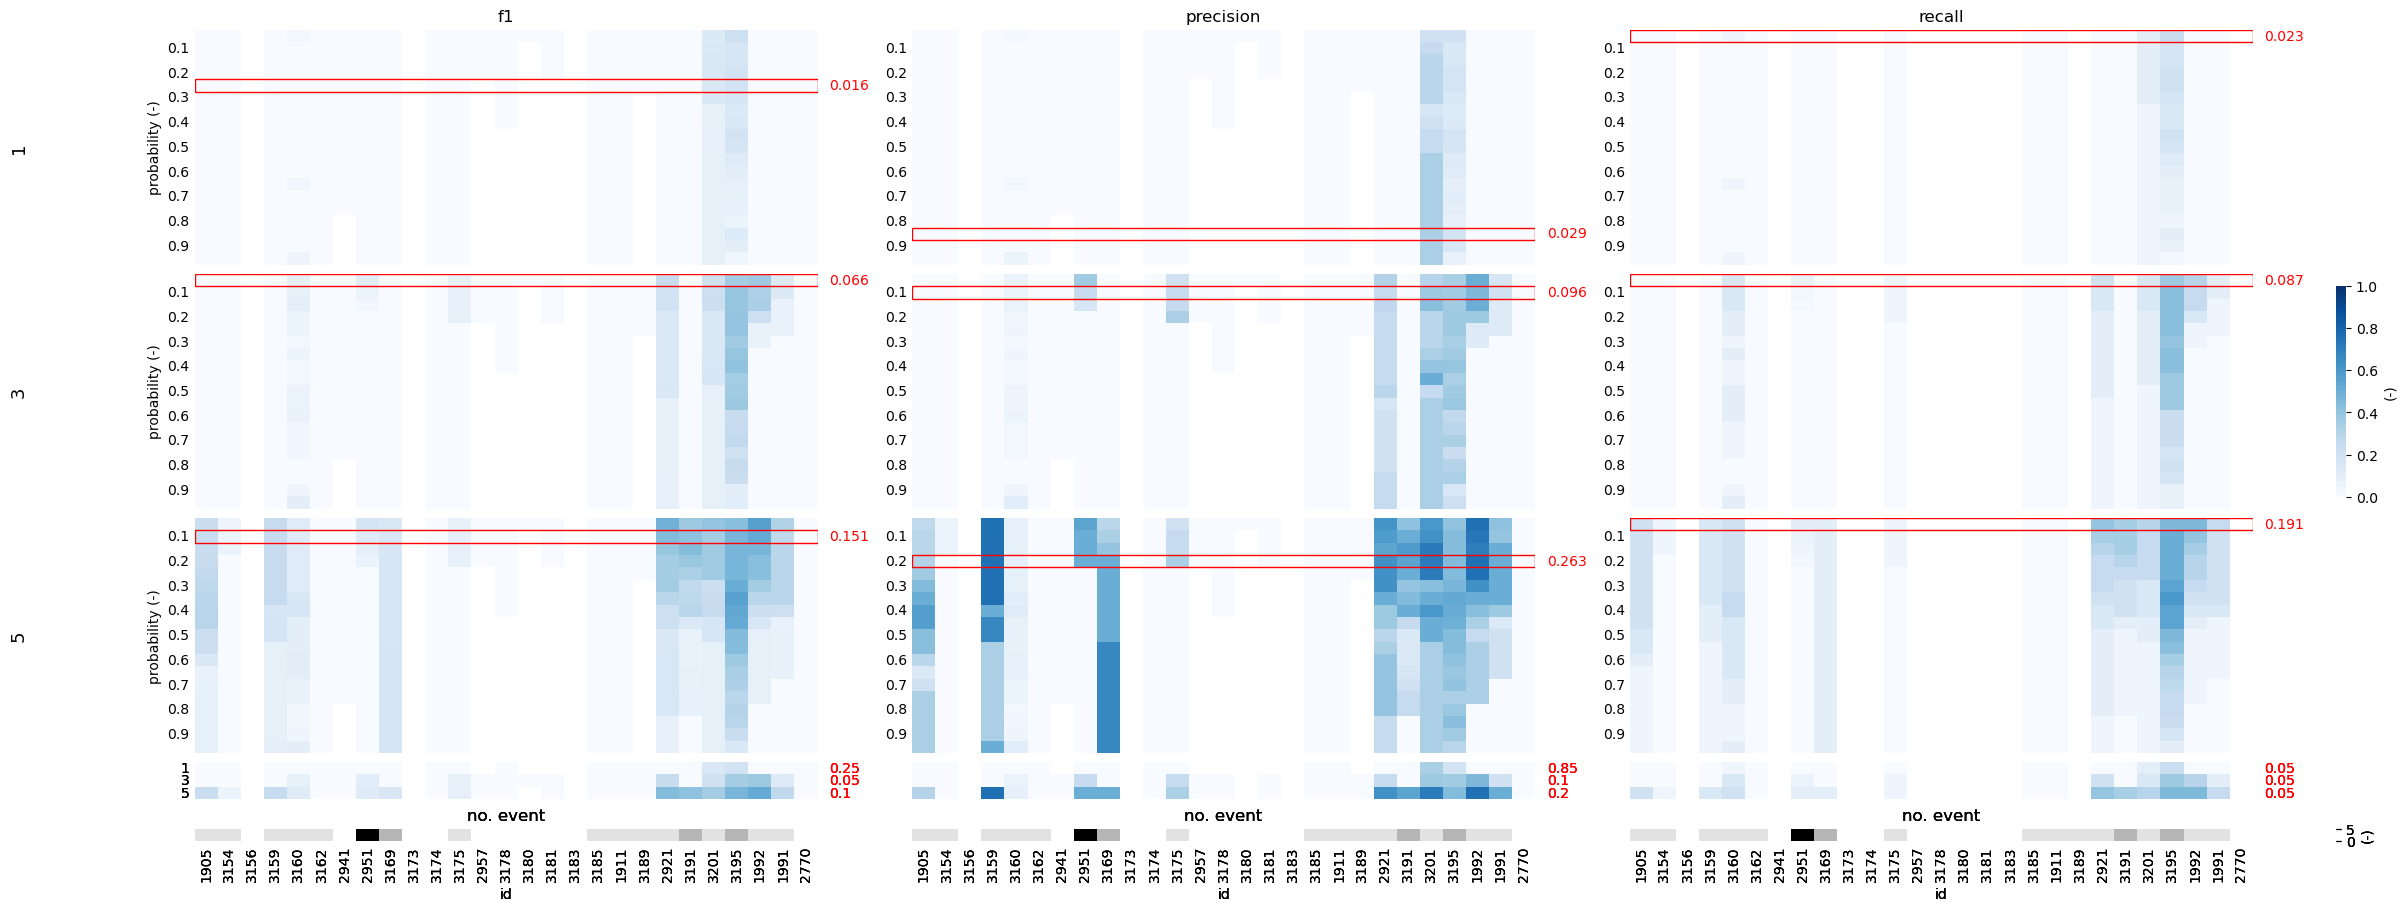

In [17]:
# plot results for a model depending on the window
plot_skill(results22.sel(model='current'), rean_events.sum(), rowdim='window')

Conclusions from the previous plot:

* The skill scores are clearly lower when we look at the onset of the flood than when we look at the complete forecast (previous section). If in the previous section we reached average scores up to 0.50, in this section we only reach values close to 0.3.
* As it was expected, the skill increases as we widen the forecast window. As expeceted, predicting the exact timestep (window 1) is an extremely hard task (f1 values close to 0).
* The same 9 stations that were identified in the previous section are those with higher scores in this analysis.
* The `precision` values are slightly higher than `recall`, which means the model is somehow reliable when it predicts a flood, but it misses some floods.

**Plot id vs model**

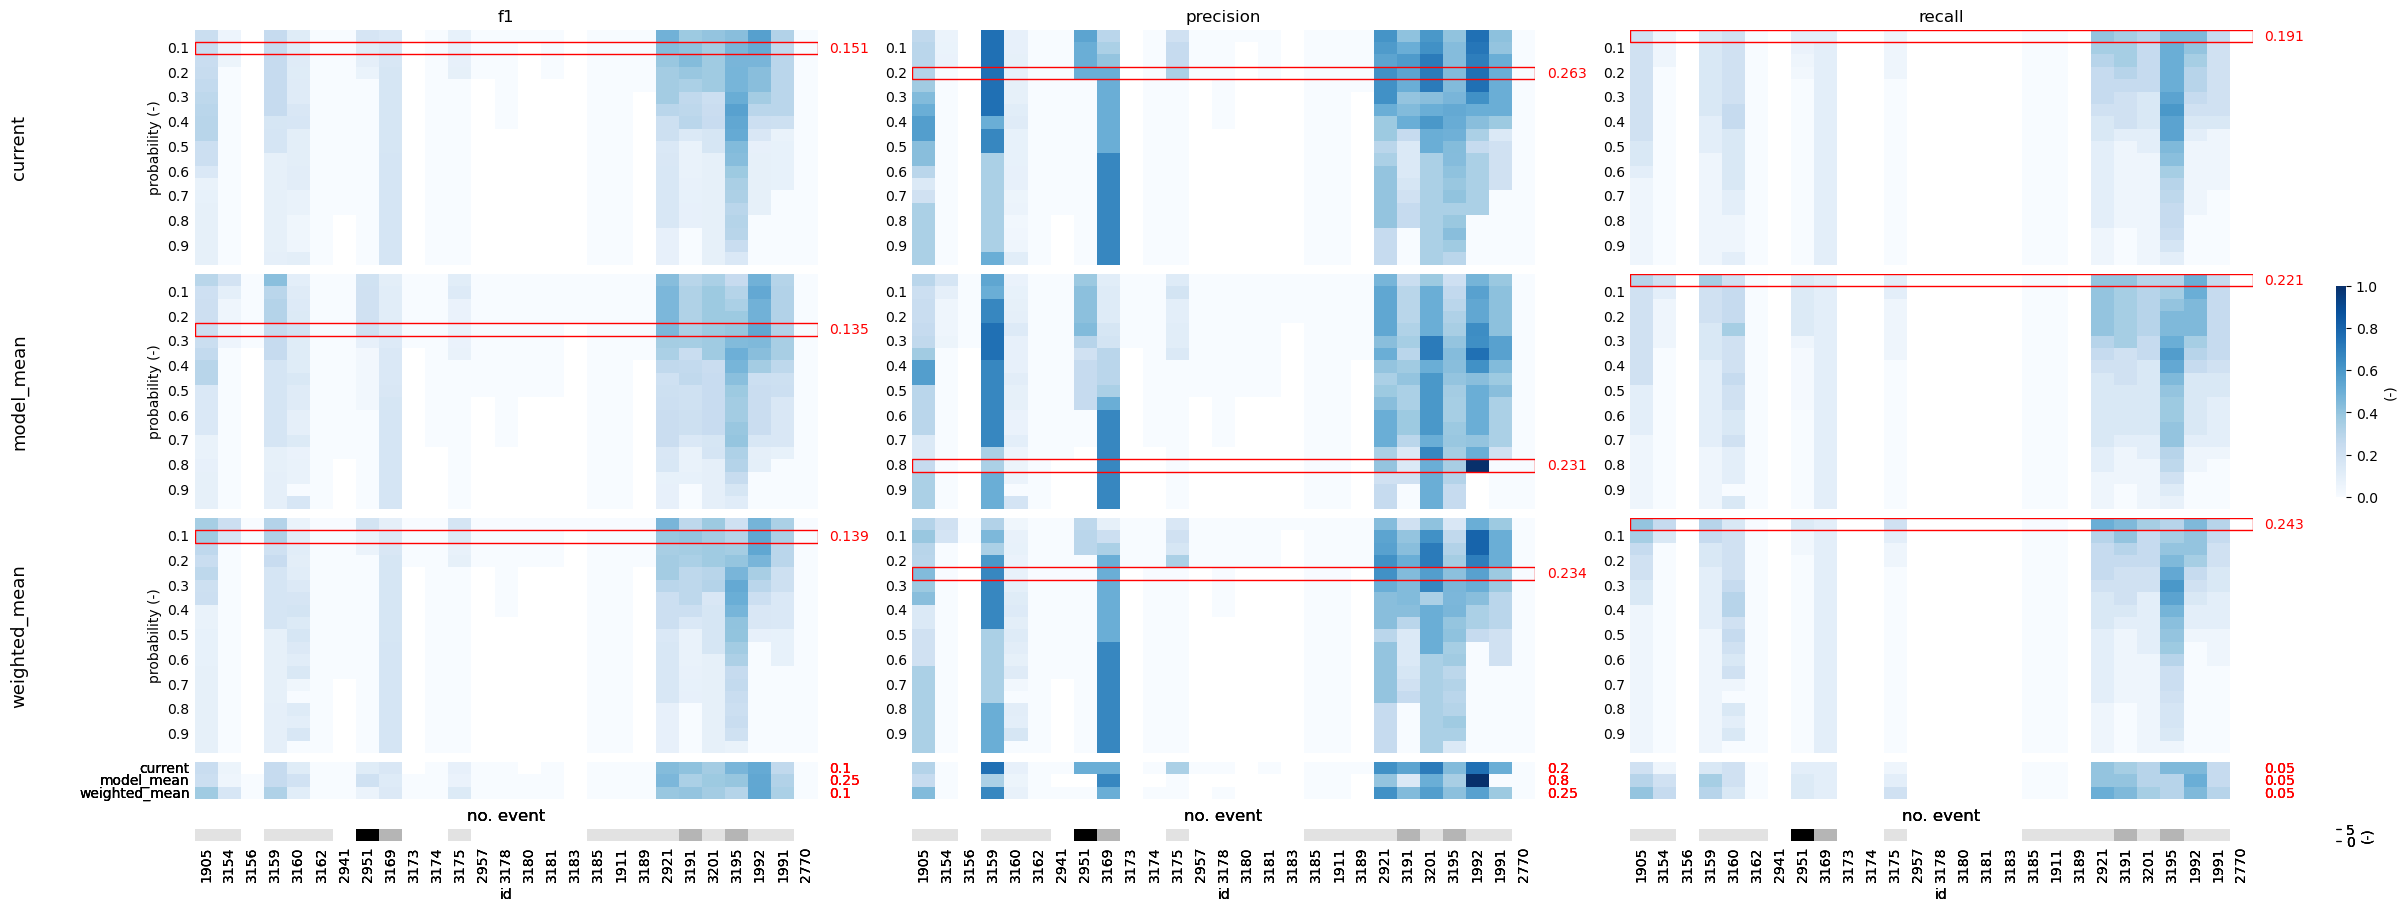

In [18]:
# plot results for a window depending on the model
plot_skill(results22.sel(window=5), rean_events.sum(), rowdim='model')

To the conclusions of the previous plot, this plot adds the foloowing:

* From the three models, the `current` criteria is the highest performing in terms of `f1`. To reach this performance, however, the probability threshold must be raised to 50%.
* The `weighted_mean` has a performace close to the previous, even higher in terms of `recall`. The probability threshold in this model is lower (20% for `f1` and 30 % for precision).
* As in the previous plot, `recall` shows lower values than precision, even though in all the 3 models the probability threshold was set at 5% to maximize this metric.

#### 3.2.3 Aggregation over forecast and station

The second approach is to aggregate the hits/misses _Dataset_ over the dimensions `forecast` and `station`, so we can check how performance changes over `leadtime`.

In [19]:
# compute skill
results23 = compute_metrics(hits, ['forecast', 'id'])
print(results23.dims)

Frozen({'model': 3, 'leadtime': 40, 'probability': 19, 'window': 3})


**Plot leadtime vs window**

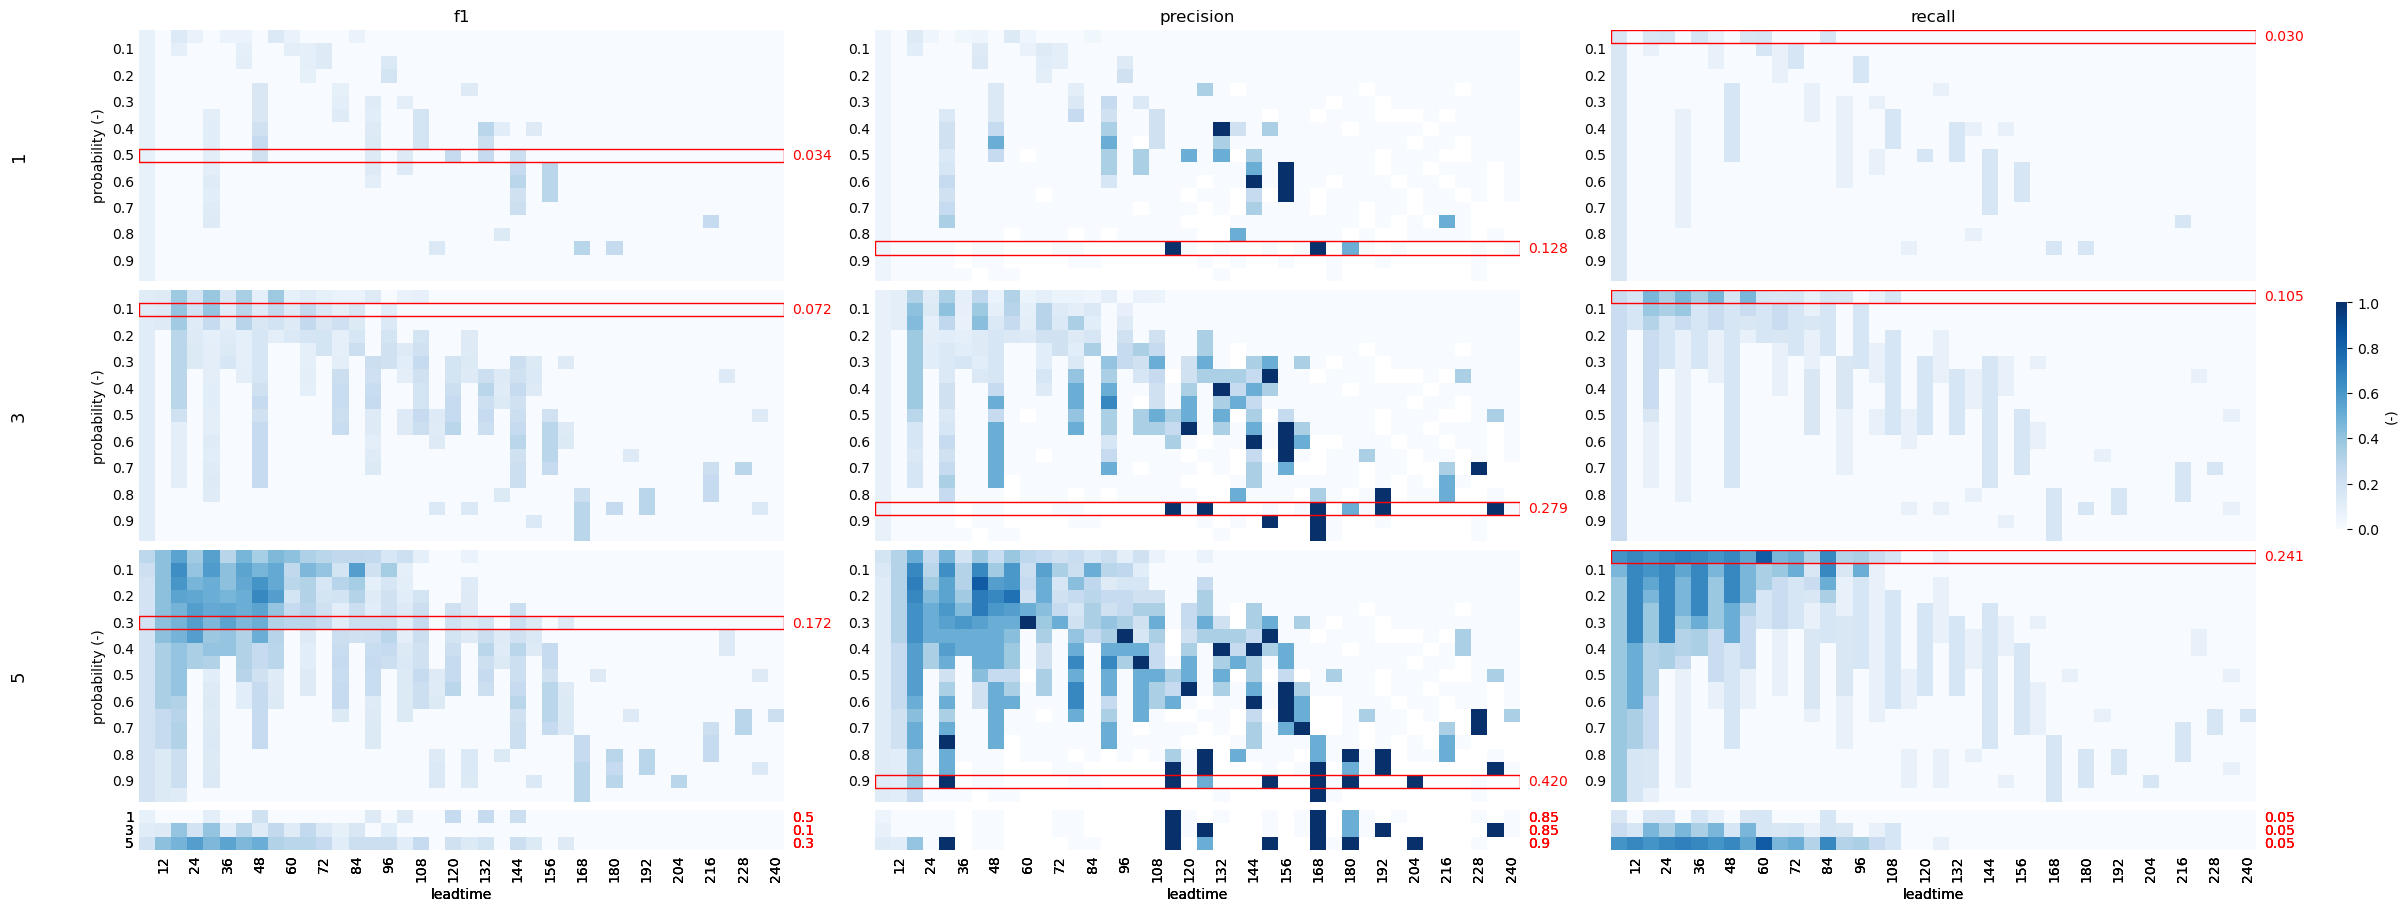

In [20]:
# plot results for a model depending on the window
plot_skill(results23.sel(model='weighted_mean'), xdim='leadtime', ydim='probability', rowdim='window', xtick_step=2)

* Performance is extremely poor when trying to predict the exact onset of the event (`window=1`). Only precision at around 5 days leadtime shows a value significantly higher than 0.
* The skill improves as the time window widens.
* As expected, skill is higher at shorter leadtimes, with the exception of leadtime 6 h..
* The optimal probability threshold changes depending on the metric and the window.
* The different model resolution (6 h) and forecast frequency (12 h) causes some noice in the `leadtime` dimension that hinders conclusions.

**Plot leadtime vs model**

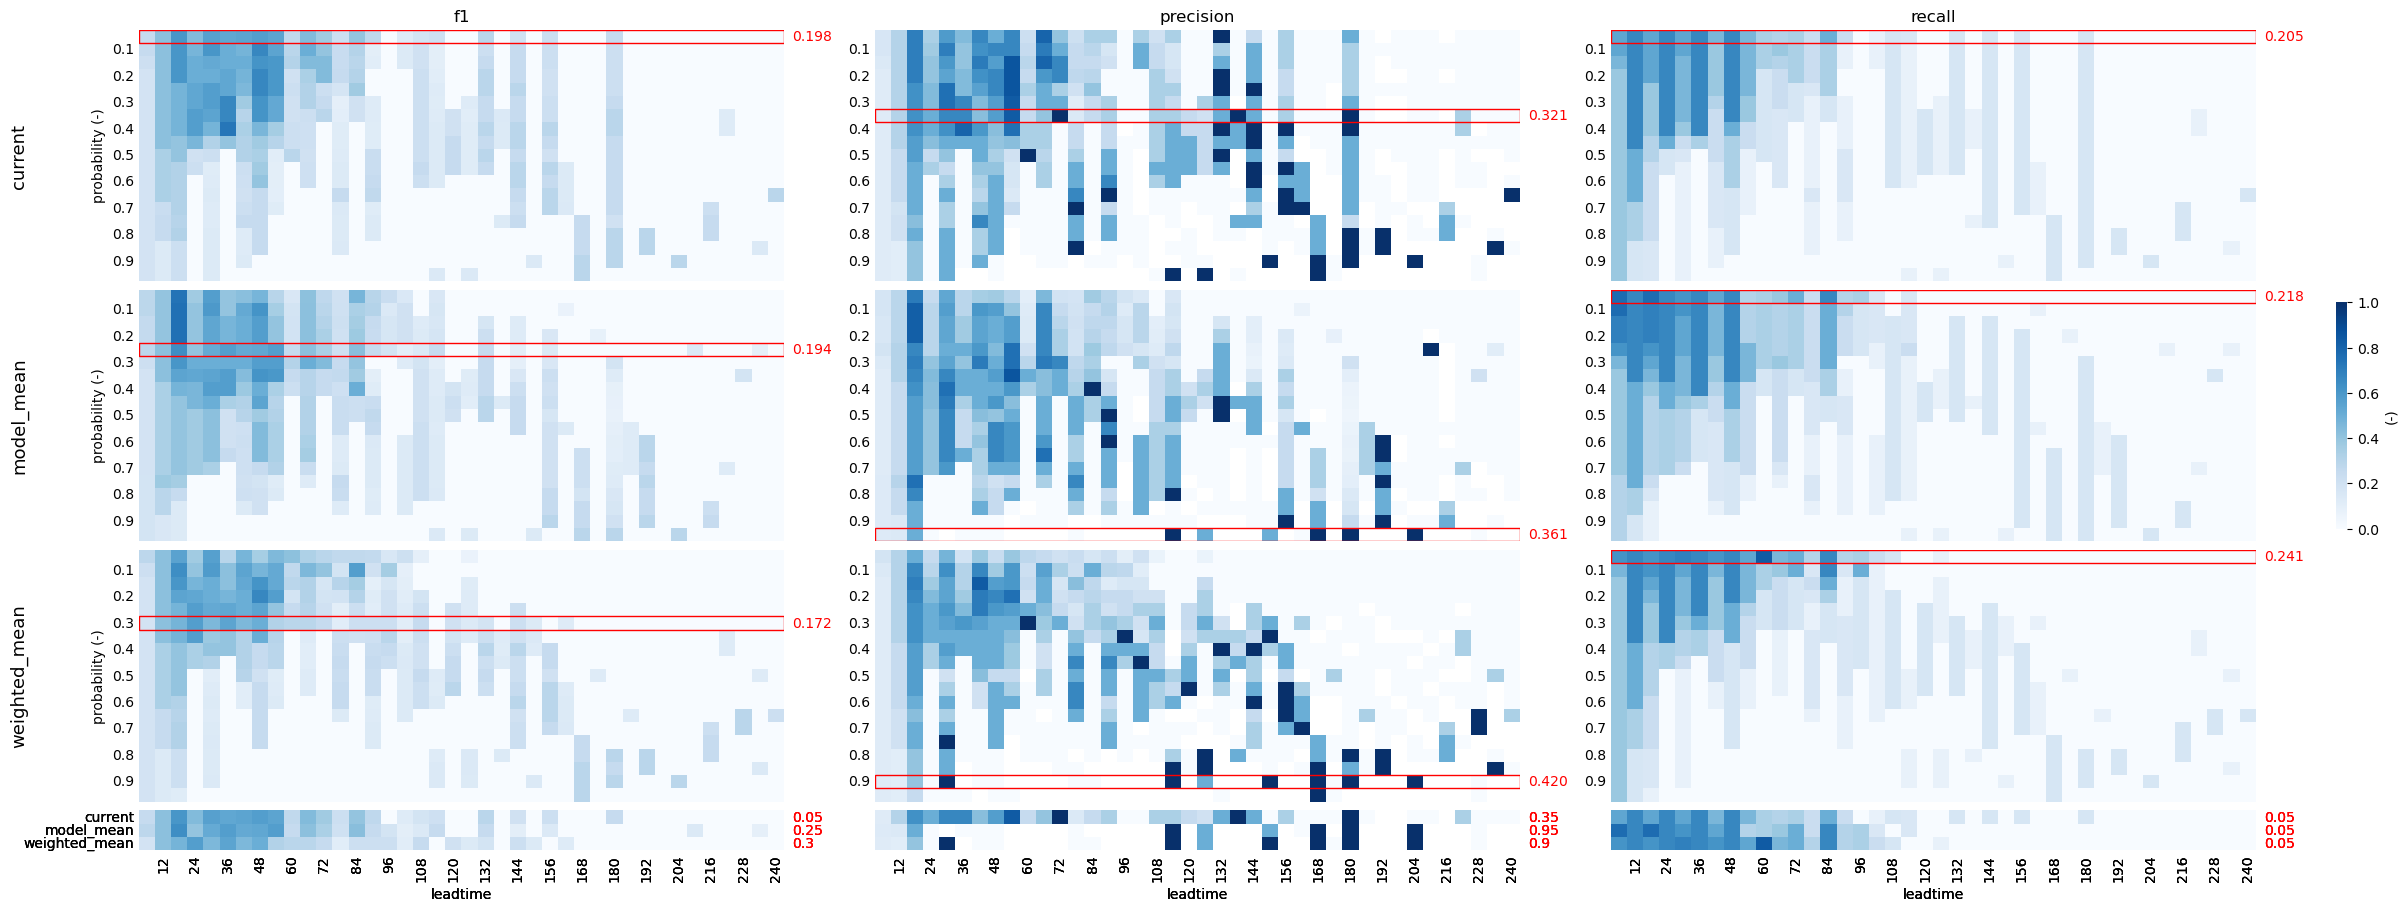

In [27]:
# plot results for a model depending on the window
plot_skill(results23.sel(window=5), xdim='leadtime', ydim='probability', rowdim='model')

# plt.savefig(f'{path_out}/skill_models_leadtime.jpg', dpi=300, bbox_inches='tight')

* The pattern is similar regardless the model. 
    * Skill increases towards shorter leadtimes and lower probability thresholds.
    * Precision values are significantly higher than recall.
    * Recall is maximized by the minimum probability threshold.
* The highest f1 value is found for the `model_mean` and a probability threshold of 30%.
* This plot shows the same noise in the leadtime dimension.

##### Resampling hits/misses to 12-hourly resolution

To avoid the noise in the `leadtime` dimension caused by the fact that the model resolution is 6 h, but the forecast frequency is 12 h, I propose to resample the `hits` _Dataset_ to 12 h resolution.

In [22]:
# resample the dataset of hits and misses
resample_dict = {'leadtime': '12h'}
hits_12h = hits.resample(resample_dict).any()

# compute skill
results23_12h = compute_metrics(hits_12h, ['forecast', 'id'])
results23_12h.dims

Frozen({'leadtime': 20, 'model': 3, 'probability': 19, 'window': 3})

**Plot leadtime vs window**

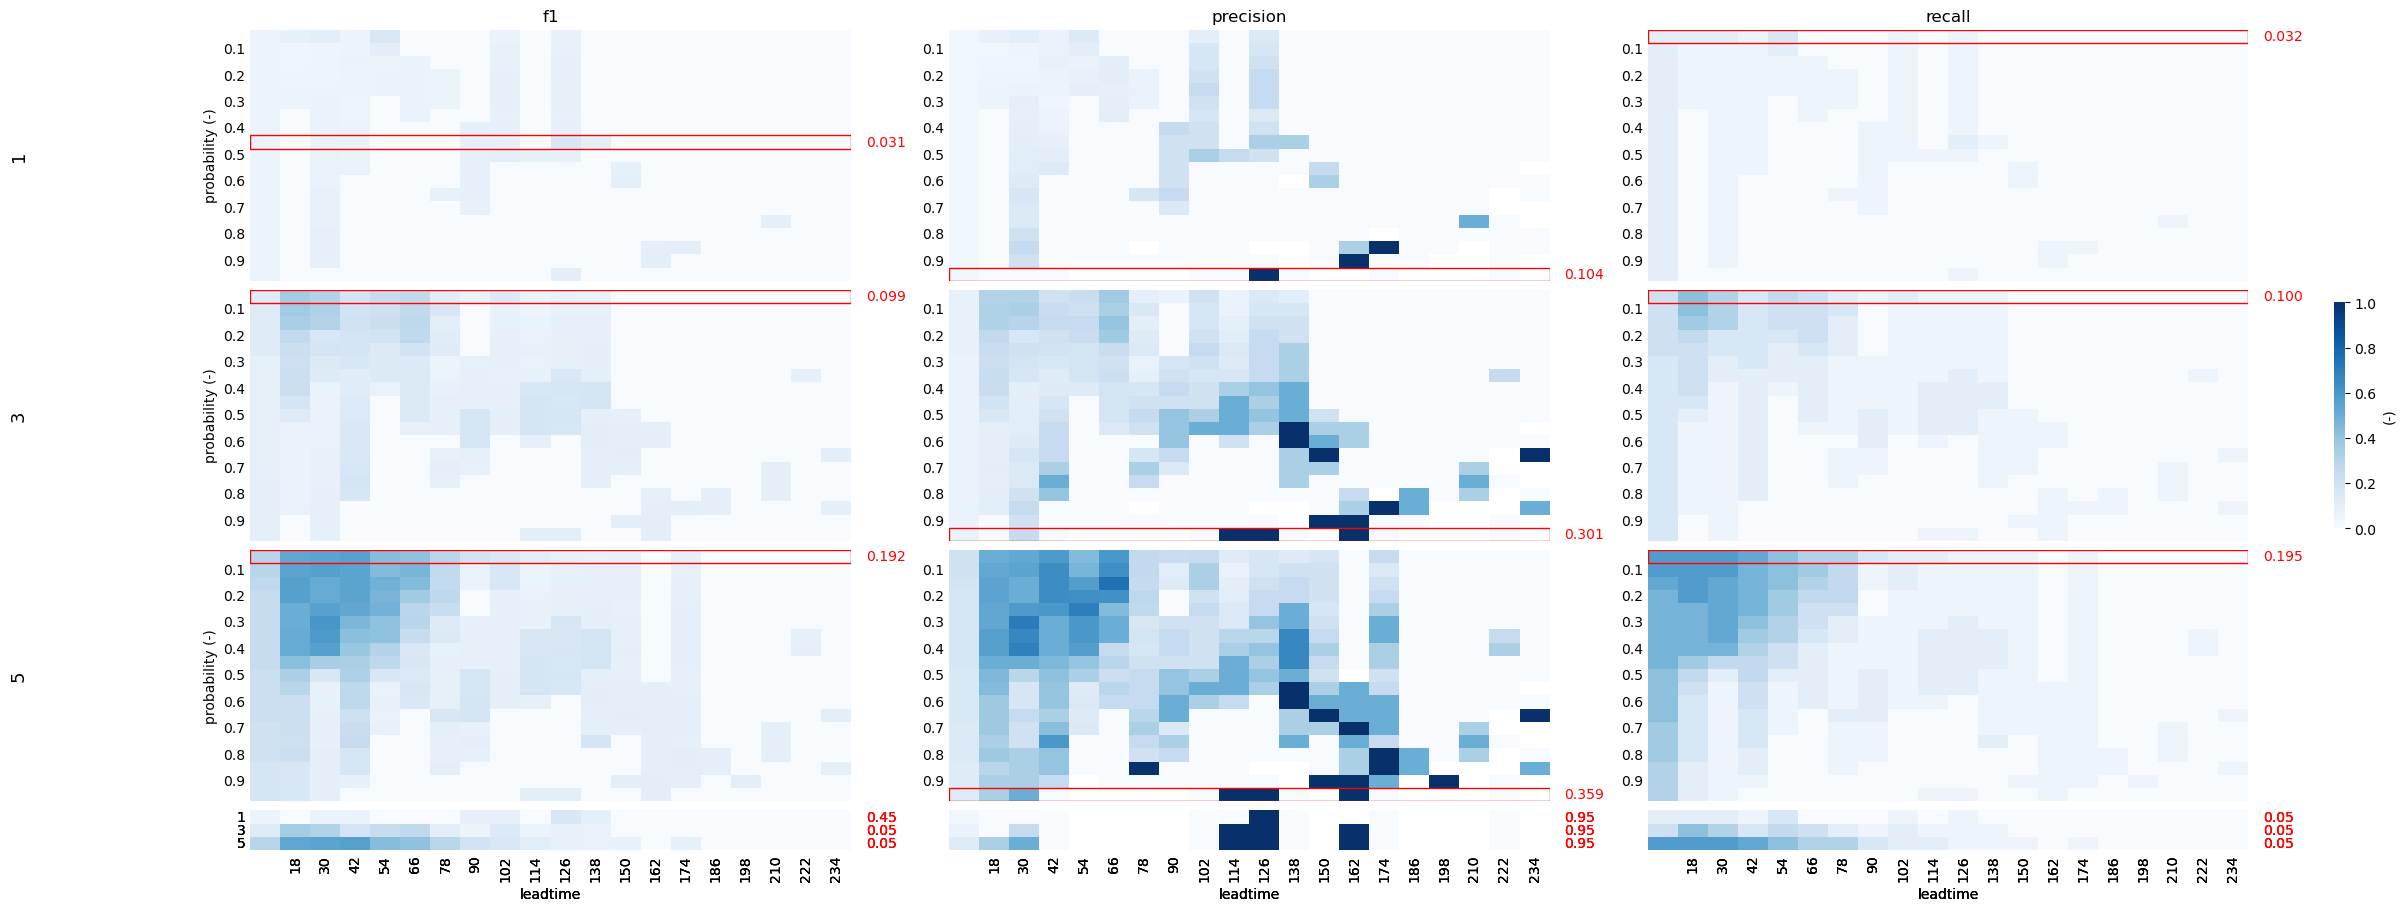

In [23]:
# plot results for a model depending on the window
plot_skill(results23_12h.sel(model='current'), xdim='leadtime', ydim='probability', rowdim='window', xtick_step=1)

The results are clearer than with the 6-hourly resolution, but show the same pattern:
* Performance increases as we increase the wime window.
* Precision has higher values than recall, which actually requires the minimum probability threshold.
* Skill is higher at shorter leadtimes, with the exception of the first step.

**Plot leadtime vs model**

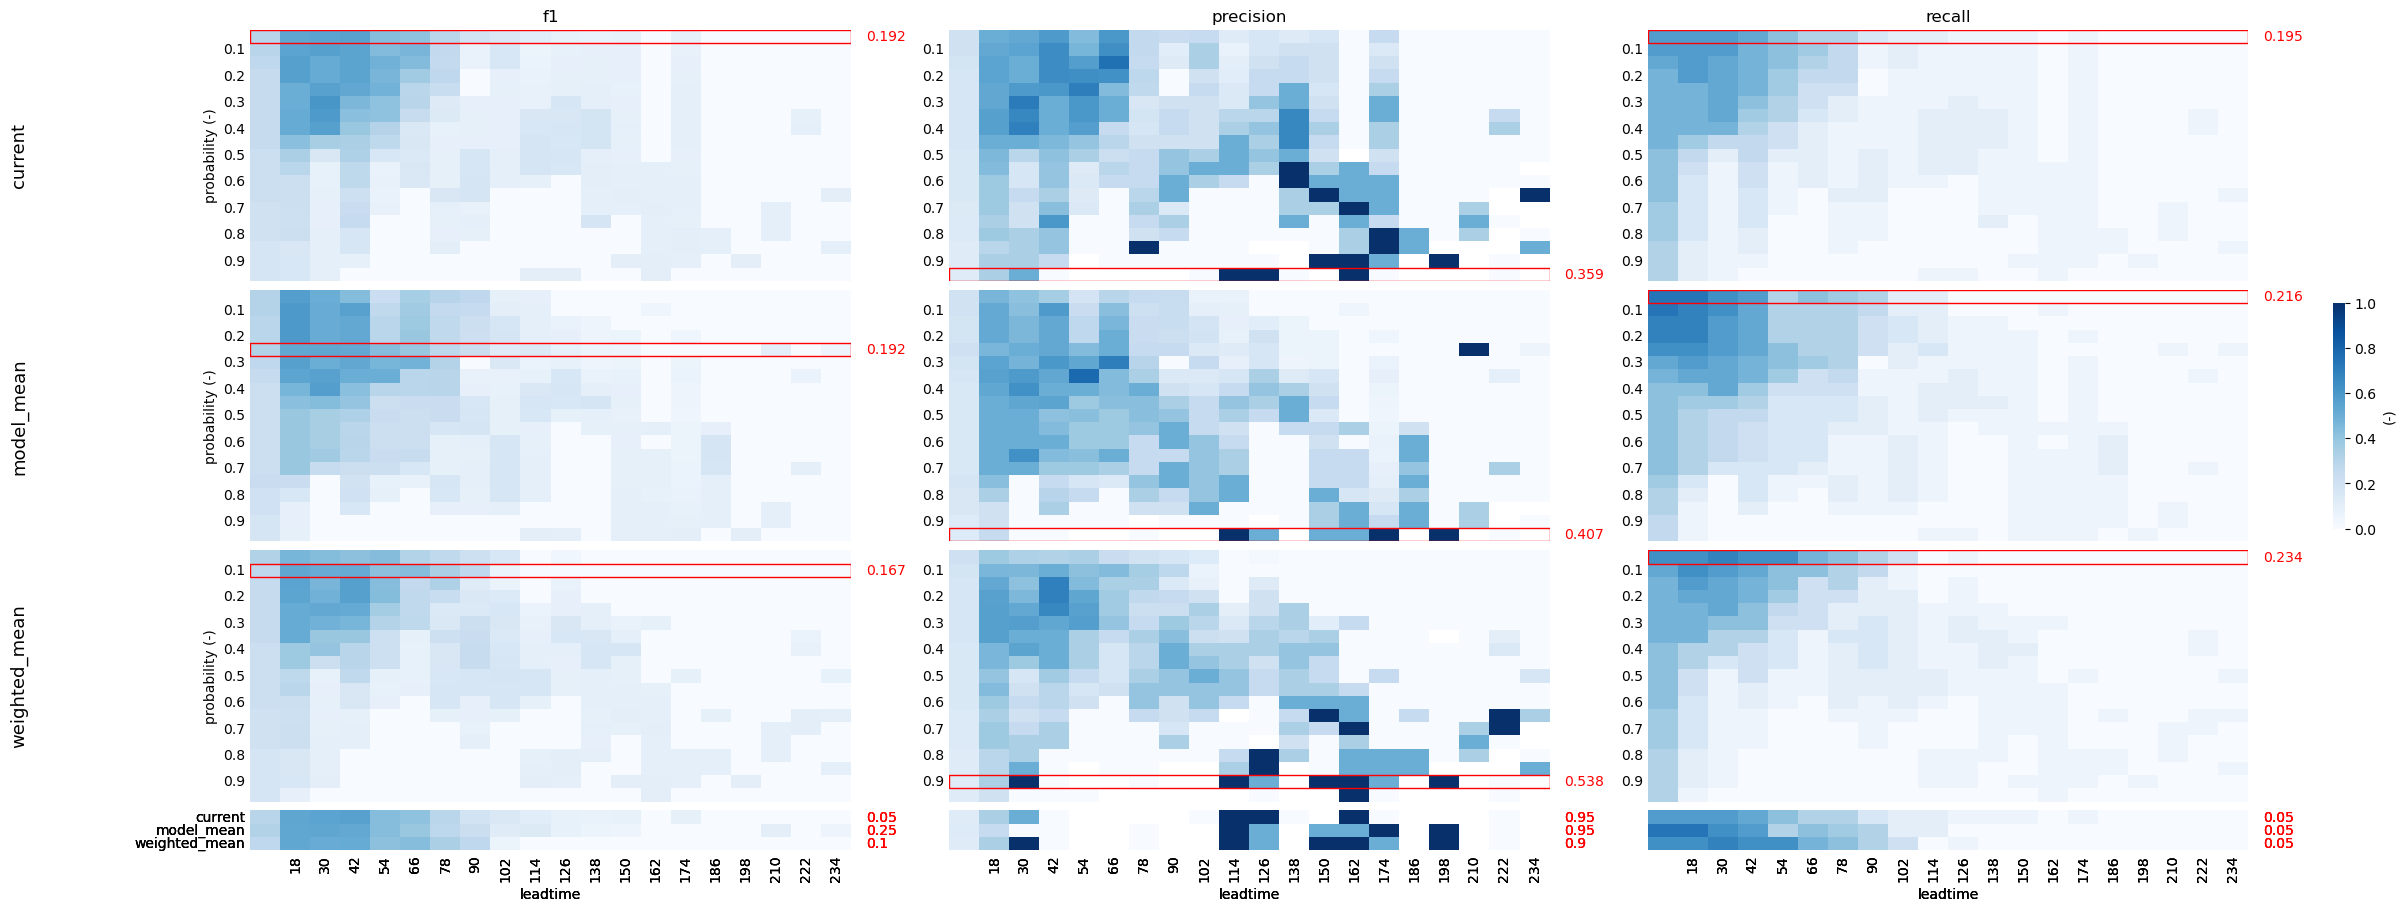

In [24]:
# plot results for a model depending on the window
plot_skill(results23_12h.sel(window=5), xdim='leadtime', ydim='probability', rowdim='model', xtick_step=1)

The conclusions are similar to the 6-hourly plot:
* The pattern is similar regardless the model. 
    * Skill increases towards shorter leadtimes (except the first step).
    * Skill maximizes at probability thresholds between in the lower range, but not minium (except recall).
    * Precision values are significantly higher than recall.
* The highest f1 value is found for the `model_mean` and a probability threshold of 35%.